# Create local topography maps from different DEM sources with OGGM

There are a number of datasets available [out-of-the box](https://rgitools.readthedocs.io/en/latest/dems.html) in OGGM. This Notebook will show you how to download the original sources and create the local glacier centered map.
It is also possible to use your own DEM data in OGGM.

## Set-up 

In [1]:
import numpy as np
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import oggm
from oggm import cfg, utils, workflow, tasks, graphics
from oggm.core import gis
cfg.initialize(logging_level='WARNING')
cfg.PARAMS['border'] = 10

2021-02-03 13:18:27: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2021-02-03 13:18:27: oggm.cfg: Multiprocessing switched ON according to the parameter file.
2021-02-03 13:18:27: oggm.cfg: Multiprocessing: using all available processors (N=8)
2021-02-03 13:18:28: oggm.cfg: PARAMS['border'] changed from `20` to `10`.


## RGI outlines 

We use the RGI outlines to identify the necessary DEM tiles. If you haven't downloaded the RGI files yet, this will also download them. Feel free to use your desired RGI-ID here, otherwise let's use the Hintereisferner glacier as an example. 

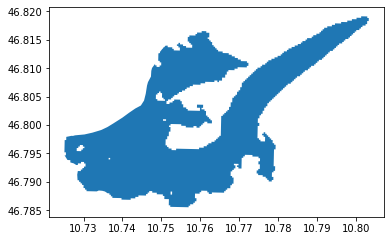

In [2]:
entity = utils.get_rgi_glacier_entities(['RGI60-11.00897'])
entity.plot();

## The default 

If not specifying anything, OGGM will use it's default settings, i.e. NASADEM mid- and low-latitudes:

In [3]:
# Let's make a working directory for this DEM 
cfg.PATHS['working_dir'] = utils.gettempdir('default', reset=True)
gdir = workflow.init_glacier_directories(entity)[0]
tasks.define_glacier_region(gdir)

2021-02-03 13:18:30: oggm.workflow: Execute entity task GlacierDirectory on 1 glaciers


You can access the (reprojected and interpolated) DEM file in the working directory:

In [4]:
dem_path = gdir.get_filepath('dem')
dem_path

'/tmp/OGGM/default/per_glacier/RGI60-11/RGI60-11.00/RGI60-11.00897/dem.tif'

It is a geotiff file. [Xarray](http://xarray.pydata.org) can open them thanks to [rasterio](https://rasterio.readthedocs.io):

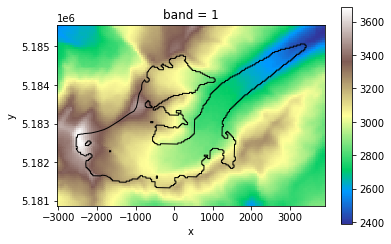

In [5]:
da = xr.open_rasterio(dem_path)
f, ax = plt.subplots()
da.plot(cmap='terrain', ax=ax);
# Add the outlines
gdir.read_shapefile('outlines').plot(ax=ax, color='none', edgecolor='black');

The source of the DEM is documented in the directory itself:

In [6]:
with open(gdir.get_filepath('dem_source'), 'r') as f:
    print(f.read())

NASADEM Merged DEM Global

Original resolution: 1 arcsec (~30m)
Date of acquisition: February 2000
Date range: 2000-2000

# Data Citation

NASADEM Merged DEM Global 1 arc second - NASADEM_HGT
NASA JPL (2020). NASADEM Merged DEM Global 1 arc second V001 [Data set]. NASA
EOSDIS Land Processes DAAC. Accessed YYYY-MM-DD from
https://doi.org/10.5067/MEaSUREs/NASADEM/NASADEM_HGT.001

# Data files

n46e010.hgt



**OGGM is neither the owner nor the distributer of these datasets! OGGM only provides tools to access it. It is your responsibility as the data user to read the individual usage requirements and cite and acknowledge the original data sources accordingly.**

## OGGM provided datasets

At the moment OGGM is able to download and process the following DEM sources:

In [7]:
for src in utils.DEM_SOURCES:
    print('{:<10}: {}'.format(src, gis.DEM_SOURCE_INFO[src].split('\n')[0]))

GIMP      : GIMP V1.1
ARCTICDEM : ARCTICDEM V3
RAMP      : RAMP V2
TANDEM    : TanDEM-X 90m
AW3D30    : AW3D30 V1804
MAPZEN    : MAPZEN TERRAIN TILES
DEM3      : VIEWFINDER PANORAMAS DEMs
ASTER     : ASTGTMV3
SRTM      : SRTM V4
REMA      : REMA V1.1
ALASKA    : ALASKA V3
COPDEM    : Copernicus DEM GLO-90
NASADEM   : NASADEM Merged DEM Global


At the moment three of these sources, **TanDEM-X**, **COPDEM** and **ASTGTMV3** reqire a user account to download data. You need to register at [NASA Earthdata](https://urs.earthdata.nasa.gov/) for ASTGTMV3, at [DLR](https://sso.eoc.dlr.de/tdm90/selfservice/) for TanDEM-X, and at [spacedata.copernicus.eu/](https://spacedata.copernicus.eu) for COP-DEM.

After that you can use the command line functionality `oggm_netrc_credentials` to store your user credentials in a local `~/.netrc` file.
Your user credentials are only stored locally and are only used by the download function for authentification with the original DEM source. **Credentials are not needed if you use the RGI-TOPO data (see below).**

## Use pre-processed DEMs from RGI-TOPO 

The [RGI-TOPO](https://rgitools.readthedocs.io/en/latest/dems.html) dataset is an RGI-provided dataset in beta release. These data are available for everyone, and where created with OGGM. Of course you can easily use these data in OGGM as well:

2021-02-03 13:18:35: oggm.workflow: init_glacier_directories from prepro level 1 on 1 glaciers.
2021-02-03 13:18:35: oggm.workflow: Execute entity task gdir_from_prepro on 1 glaciers
2021-02-03 13:18:35: oggm.workflow: Execute entity task select_dem_from_dir on 1 glaciers


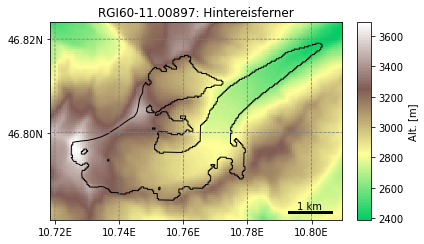

In [8]:
from oggm.shop import rgitopo
cfg.PATHS['working_dir'] = utils.gettempdir('rgitopo', reset=True)
gdir = rgitopo.init_glacier_directories_from_rgitopo(['RGI60-11.00897'], dem_source='COPDEM')[0]
graphics.plot_domain(gdir)

## Use another DEM source

Using RGI-TOPO dems is by far the easiest since all data is prepared for you and ready to use. But if you really want, you can go back to the original data sources:

In [9]:
# Let's make a working directory for this DEM 
cfg.PATHS['working_dir'] = utils.gettempdir('alternative')
try:
    gdir = workflow.init_glacier_directories(entity)[0]
    tasks.define_glacier_region(gdir, source='DEM3')
except oggm.exceptions.InvalidDEMError as err:
    print(err)

2021-02-03 13:18:36: oggm.workflow: Execute entity task GlacierDirectory on 1 glaciers


Let's check that the source text is updated as well:

In [10]:
with open(gdir.get_filepath('dem_source'), 'r') as f:
    print(f.read())

VIEWFINDER PANORAMAS DEMs

Original resolution: 3 arcsec (~90m)
Date of acquisition: Depending on original source

These data are downloaded from Jonathan de Ferranti's webpage:
http://viewfinderpanoramas.org/dem3.html

# Data Citation

There is no recommended citation for these data. Please refer to the website
above in case of doubt.


# Data files

L32.tif



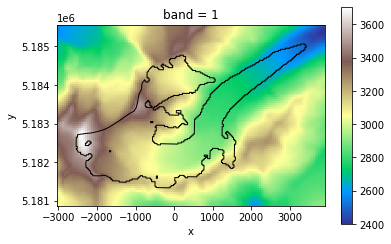

In [11]:
f, ax = plt.subplots()
da_dem3 = xr.open_rasterio(gdir.get_filepath('dem'))
da_dem3.plot(cmap='terrain', ax=ax);
gdir.read_shapefile('outlines').plot(ax=ax, color='none', edgecolor='black');

There might not be much difference a first sight, but by subtracting them the difference become clear:  

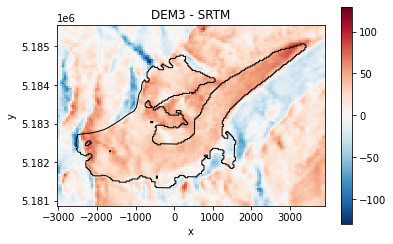

In [12]:
f, ax = plt.subplots()
(da_dem3 - da).plot(ax=ax);
plt.title('DEM3 - SRTM');
gdir.read_shapefile('outlines').plot(ax=ax, color='none', edgecolor='black');

## Regional DEMs / DEM availability

Of course not all sources are available for every glacier as some of the DEMs are regional only. If we for example try the GIMP DEM, which is a Greenland specific DEM, it will not work for glaciers outside that region:

In [13]:
# Let's make a working directory for this DEM 
cfg.PATHS['working_dir'] = utils.gettempdir('gimp', reset=True)
try:
    gdir = workflow.init_glacier_directories(entity)[0]
    tasks.define_glacier_region(gdir, source='GIMP')
except oggm.exceptions.InvalidDEMError as err:
    print(err)

2021-02-03 13:18:39: oggm.workflow: Execute entity task GlacierDirectory on 1 glaciers
2021-02-03 13:18:40: oggm.core.gis: Source: GIMP may not be available for glacier RGI60-11.00897 with border 10


## User provided DEM 

Users should be able to use any DEM file which can be opened by rasterio (i.e. geotiff). Here, we use a subset SRTM file shipped with OGGM as an example:

In [14]:
custom_dem_path = utils.get_demo_file('hef_srtm.tif')
custom_dem_path

'/home/mowglie/.oggm/oggm-sample-data-b885e9acc48037a030decb7daf73d44b4398e5e1/test-files/hef_srtm.tif'

We tell OGGM to use it by changing the entry in the RGI table and by giving the path to the file:

In [15]:
cfg.PATHS['dem_file'] = custom_dem_path

In [16]:
cfg.PATHS['working_dir'] = utils.gettempdir('user', reset=True)
gdir = workflow.init_glacier_directories(entity)[0]
tasks.define_glacier_region(gdir, source='USER')

2021-02-03 13:18:41: oggm.workflow: Execute entity task GlacierDirectory on 1 glaciers


Now the user provided DEM is used:

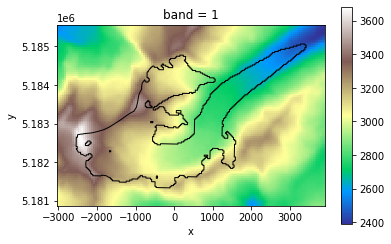

In [17]:
f, ax = plt.subplots()
da_user = xr.open_rasterio(gdir.get_filepath('dem'))
da_user.plot(cmap='terrain', ax=ax);
gdir.read_shapefile('outlines').plot(ax=ax, color='none', edgecolor='black');

## The border value, or how to chose the size of the topographic map

It is possible to specify the extent of the local topographic map. All maps are centered on the glacier and the size of the map is determined in grid points arount the glacier. The default number of grid points, which was also used in the examples above is 20.
But depending on your study you might need a larger topographic map. Or if you only need the glacier extent and want to save storage and traffic you can also reduce it.

OGGM's [pre-processed directories](https://docs.oggm.org/en/latest/input-data.html#pre-processed-directories) come in 4 border sizes: 10, 80, 160 and 250. But if you process the topography yourself you can chose every value.

In [18]:
cfg.PARAMS['border'] = 1

2021-02-03 13:18:44: oggm.cfg: PARAMS['border'] changed from `10` to `1`.


2021-02-03 13:18:44: oggm.workflow: Execute entity task GlacierDirectory on 1 glaciers


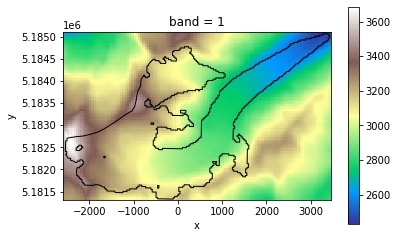

In [19]:
# Let's make a working directory for this DEM 
cfg.PATHS['working_dir'] = utils.gettempdir('border1')
gdir = workflow.init_glacier_directories(entity)[0]
tasks.define_glacier_region(gdir)
da = xr.open_rasterio(gdir.get_filepath('dem'))
f, ax = plt.subplots()
da.plot(cmap='terrain', ax=ax);
# Add the outlines
gdir.read_shapefile('outlines').plot(ax=ax, color='none', edgecolor='black');

In [20]:
cfg.PARAMS['border'] = 100

2021-02-03 13:18:45: oggm.cfg: PARAMS['border'] changed from `1` to `100`.


2021-02-03 13:18:45: oggm.workflow: Execute entity task GlacierDirectory on 1 glaciers


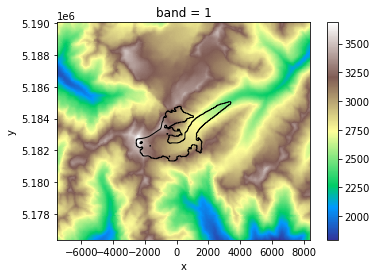

In [21]:
# Let's make a working directory for this DEM 
cfg.PATHS['working_dir'] = utils.gettempdir('border100')
gdir = workflow.init_glacier_directories(entity)[0]
tasks.define_glacier_region(gdir)
da = xr.open_rasterio(gdir.get_filepath('dem'))
f, ax = plt.subplots()
da.plot(cmap='terrain', ax=ax);
# Add the outlines
gdir.read_shapefile('outlines').plot(ax=ax, color='none', edgecolor='black');

## What's next?

- return to the [OGGM documentation](https://docs.oggm.org)
- back to the [table of contents](welcome.ipynb)